In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import gradient_descent
import least_squares
import section_search
import coordinate_descent

import torch

cuda


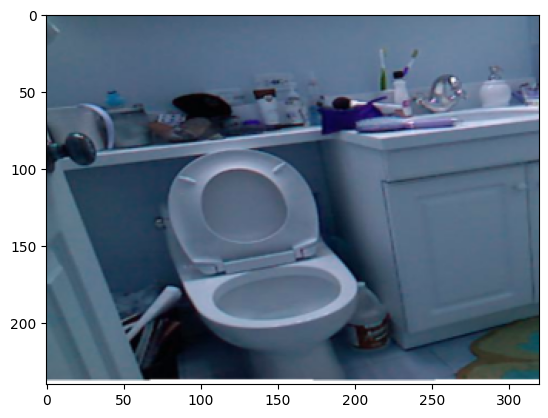

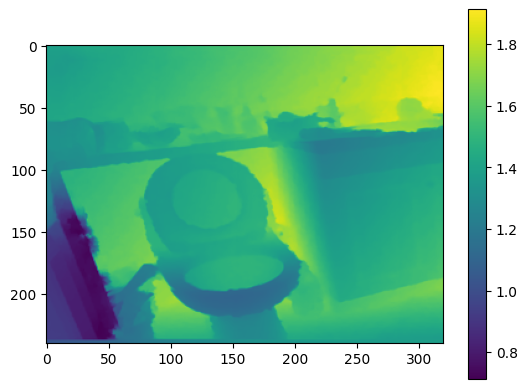

adaptive kernel size set to 11


In [2]:
globals.init_NYUv2()

# EXPERIMENT_NAME = 'coord-descent-bracket-search'
# experiment_folder = utils.create_experiment_folder(EXPERIMENT_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# load data 
# gt_aif, gt_dpt = utils.load_single_sample(sample='0045', set='train', fs=5, res='half')
gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')

plt.imshow(gt_aif)
plt.show()

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0075154924..1.0368509].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009366989..1.0104787].


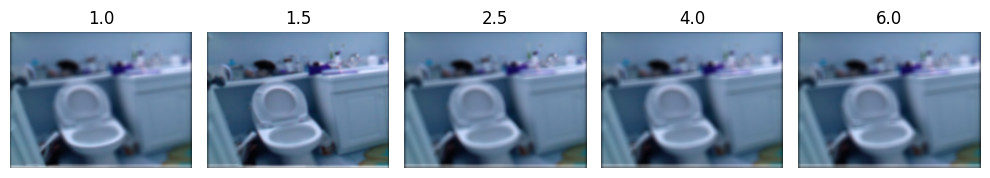

In [3]:
# forward model (torch)
defocus_stack = forward_model.forward(gt_dpt, gt_aif)
defocus_stack_torch = forward_model.forward_torch(gt_dpt, gt_aif)#.float() / 255.0)
utils.plot_single_stack(defocus_stack_torch, globals.Df)



Grid search         : 100%|███████████████████| 100/100 [01:33<00:00,  1.07it/s]


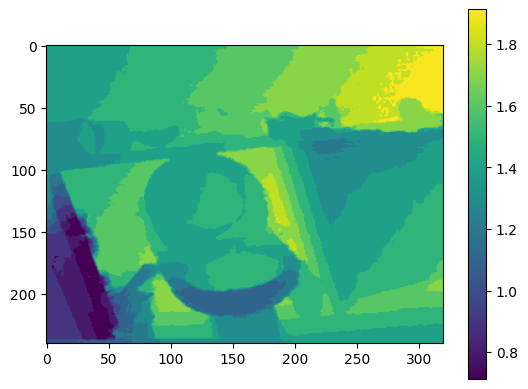

Loss: 0.0936820244477909
----------------------


In [4]:
# gt aif --> depth map
depth_map, Z, argmin_indices, all_losses = section_search.grid_search(gt_aif, defocus_stack_torch)

# utils.plot_compare_greyscale(depth_map, gt_dpt, vmin=0.7, vmax=1.9)
# plt.show()

plt.imshow(depth_map, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.colorbar()
plt.show()

criterion = torch.nn.MSELoss()
defocus_stack_pred = forward_model.forward_torch(torch.from_numpy(depth_map), gt_aif)

# utils.plot_stacks_side_by_side(defocus_stack_torch, defocus_stack_pred, globals.Df)

loss = criterion(defocus_stack_pred, defocus_stack_torch)
print('Loss:',loss.item())
print('----------------------')



Golden-section search...
...searching for 100 % convergence
...done


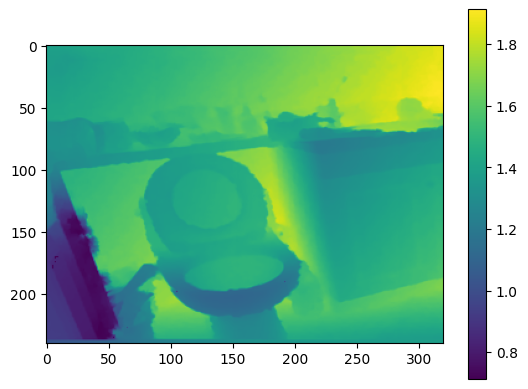

Loss: 7.622498220014874e-06


In [5]:

depth_map_golden = section_search.golden_section_search(Z, argmin_indices, gt_aif, defocus_stack_torch, max_iter=100)

# utils.plot_compare_greyscale(depth_map_golden, gt_dpt, vmin=0.7, vmax=1.9)
# plt.show()

plt.imshow(depth_map_golden, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.colorbar()
plt.show()

criterion = torch.nn.MSELoss()
defocus_stack_pred = forward_model.forward_torch(torch.from_numpy(depth_map_golden), gt_aif)
# utils.plot_stacks_side_by_side(defocus_stack_torch, defocus_stack_pred, globals.Df)

loss = criterion(defocus_stack_pred, defocus_stack_torch)
print('Loss:',loss.item())


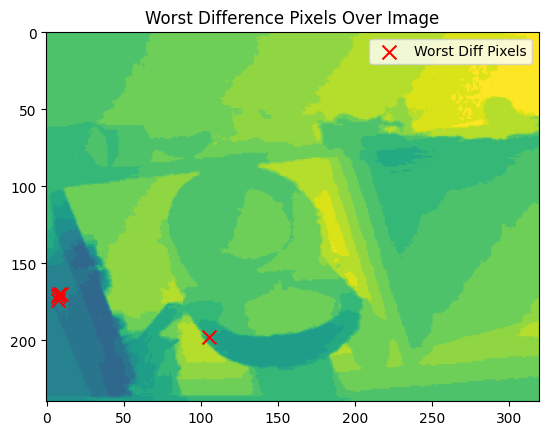

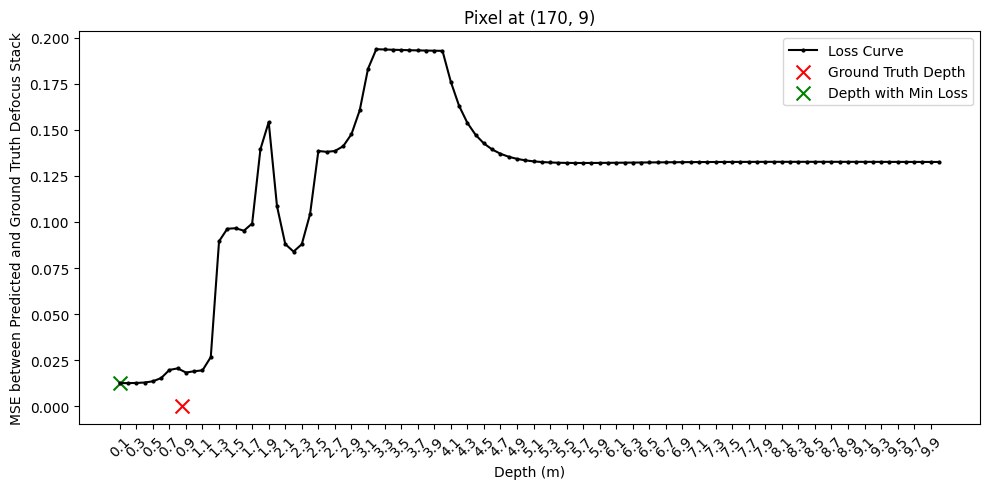

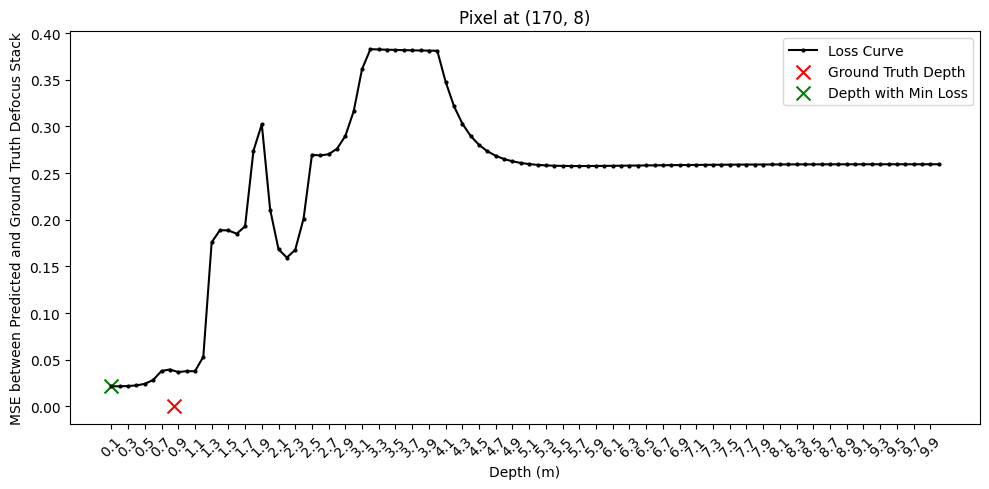

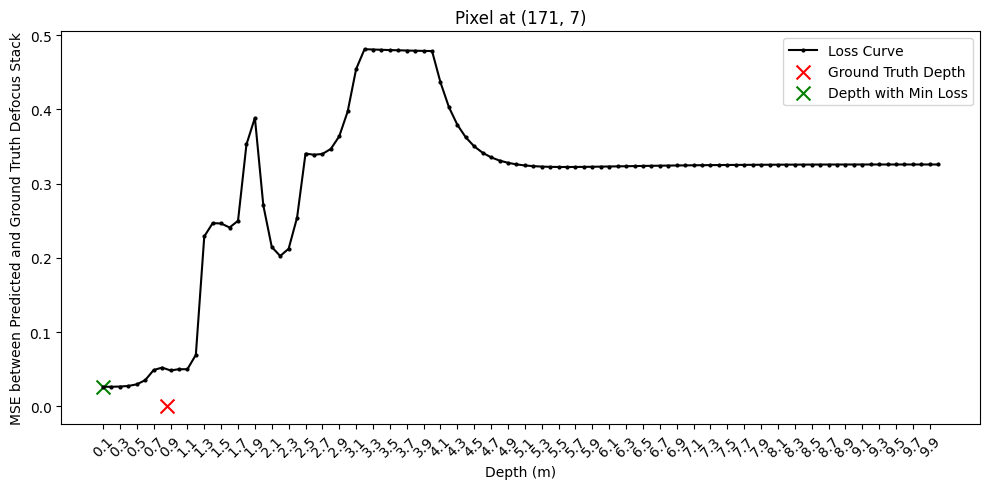

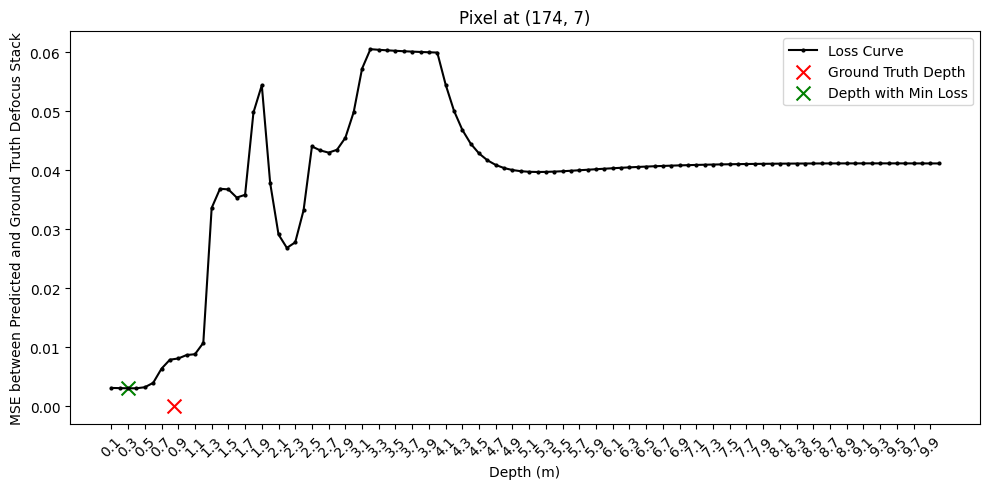

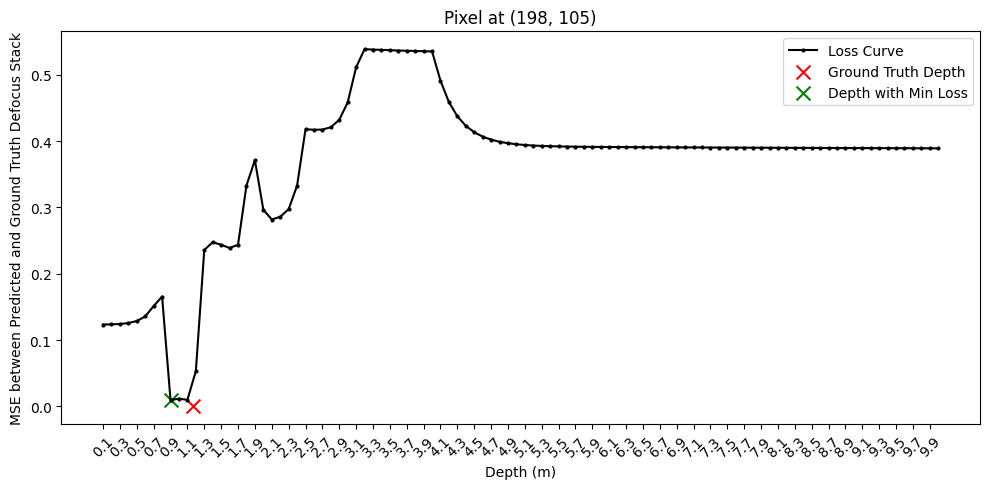

In [6]:
worst_coords = utils.get_worst_diff_pixels(torch.from_numpy(depth_map), gt_dpt,
    num_worst_pixels = 5, vmin=None, vmax=None)
for i, j in worst_coords:
    section_search.plot_grid_search_on_pixel(i.item(), j.item(), Z, all_losses, gt_dpt)

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red      1.432255  24107.579173     500
  green      1.422518  29165.813511     500
   blue      1.406872  35253.985311     500

AIF result range: [ -5.468476764483967 , 261.7335217946529 ]
Loss: 5.256485110294307e-06
Loss after clipping: 0.0005034354981034994



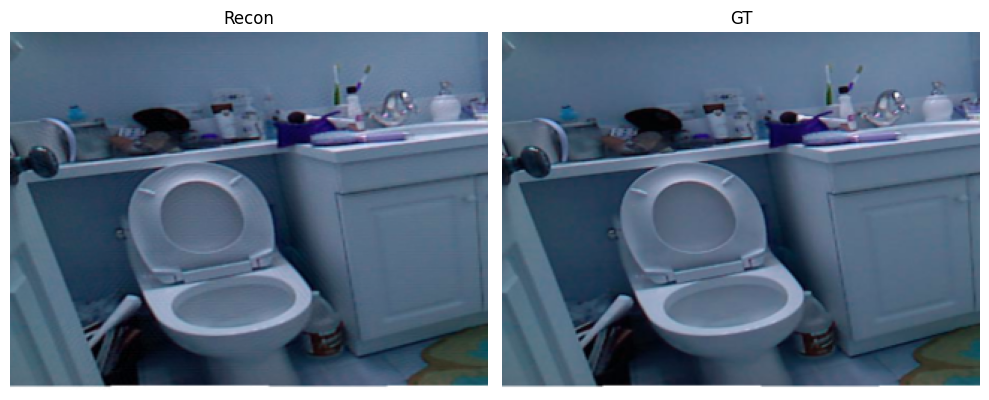

In [7]:
# -------------------
# LEAST SQUARES
# -------------------

aif = least_squares.least_squares(gt_dpt, defocus_stack)
print('\nAIF result range: [',aif.min(), ',', aif.max(),']')
        
loss = criterion(forward_model.forward_torch(gt_dpt, torch.from_numpy(aif)), defocus_stack_torch)
print('Loss:',loss.item())

aif = np.clip(aif, 0, 255)

loss = criterion(forward_model.forward_torch(gt_dpt, torch.from_numpy(aif)), defocus_stack_torch)
print('Loss after clipping:',loss.item())
print()

utils.plot_compare_rgb(aif, gt_aif)
plt.show()

In [8]:
# -------------------
# COORDINATE DESCENT
# -------------------

depth_init = 1#torch.median(gt_dpt.cpu()).item()
print('initializing depth to',depth_init)

# gradient = np.linspace(0.1, 10, width).reshape(width, 1)
# depth_init = np.tile(gradient, (1, height))
# plt.imshow(depth_init)
# plt.show()

dpt, aif = coordinate_descent.coordinate_descent(width, height, defocus_stack, save_plots=True, num_epochs=25,
                                                 depth_init=depth_init, experiment_name='coord-descent')


initializing depth to 1
Created experiment folder: experiments/coord-descent_2025-03-27_16-50-12
Iteration 0 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red   2091.275090  26421.099925     100
  green   2164.026571  31264.378013     100
   blue   2228.208473  37231.820737     100

AIF result range: [ -259.9928179681301 , 935.2098116874695 ]
Loss: 12.171364784240723 , TV: 8072825.7635448575
Loss after clipping: 39.48807907104492 , TV: 7242224.457235493



Grid search         : 100%|███████████████████| 100/100 [00:32<00:00,  3.11it/s]


Loss: 25.419616180241363

Golden-section search...
...searching for 100 % convergence
...done
Loss: 25.284640186760925 , TV: 71248.58897433901

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


--------------------------

Iteration 1 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red   1232.095129  25226.253462     100
  green   1187.302218  30043.324004     100
   blue   1157.752485  35957.064034     100

AIF result range: [ -237.2467581191606 , 951.7606279915997 ]
Loss: 3.7049795171917346 , TV: 6985427.766311804
Loss after clipping: 13.532785960505157 , TV: 6464520.847271626



Grid search         : 100%|███████████████████| 100/100 [00:32<00:00,  3.09it/s]


Loss: 12.682692277479271

Golden-section search...
...searching for 100 % convergence
...done
Loss: 12.501227141357903 , TV: 44364.83251088457

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


--------------------------

Iteration 2 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red   1011.284935  24731.742735     100
  green    959.651592  29657.321067     100
   blue    927.967903  35646.560900     100

AIF result range: [ -139.0017421267118 , 510.0359660507112 ]
Loss: 2.4346816231429935 , TV: 4971609.834948899
Loss after clipping: 5.869282147304857 , TV: 4689709.522758963



Grid search         : 100%|███████████████████| 100/100 [00:32<00:00,  3.06it/s]


Loss: 5.504250042384922

Golden-section search...
...searching for 100 % convergence
...done
Loss: 5.369216562863859 , TV: 28153.085319277812

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


--------------------------

Iteration 3 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    830.055868  24454.599310     100
  green    780.553198  29438.890386     100
   blue    758.461156  35467.753873     100

AIF result range: [ -134.51404427626974 , 461.1184205229399 ]
Loss: 1.6263191294449681 , TV: 3907248.3326292727
Loss after clipping: 3.002544412776882 , TV: 3755143.005713834



Grid search         : 100%|███████████████████| 100/100 [00:35<00:00,  2.82it/s]


Loss: 2.7331666062810314

Golden-section search...
...searching for 100 % convergence
...done
Loss: 2.6179425911420835 , TV: 19684.40808627286

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


--------------------------

Iteration 4 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    583.438382  24298.246236     100
  green    549.370786  29321.784696     100
   blue    522.742784  35372.312578     100

AIF result range: [ -117.03017300037394 , 429.75751337841524 ]
Loss: 0.7946777384127564 , TV: 3244656.797612442
Loss after clipping: 1.380976654387926 , TV: 3162533.0565611166



Grid search         : 100%|███████████████████| 100/100 [00:48<00:00,  2.07it/s]


Loss: 1.312359219938042

Golden-section search...
...searching for 100 % convergence
...done
Loss: 1.2075442341478775 , TV: 13836.399803976492

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


--------------------------

Iteration 5 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    416.954984  24208.401226     100
  green    395.712408  29246.830514     100
   blue    369.253026  35314.308680     100

AIF result range: [ -76.65862393361368 , 430.9328671434198 ]
Loss: 0.4051975943333363 , TV: 2821953.8740808954
Loss after clipping: 0.6354917866166792 , TV: 2777217.6278999615



Grid search         : 100%|███████████████████| 100/100 [00:51<00:00,  1.93it/s]


Loss: 0.6439086583038235

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.5413305763314809 , TV: 9621.534652361179

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


--------------------------

Iteration 6 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    281.214250  24144.338277     100
  green    264.091770  29193.203609     100
   blue    243.624137  35273.734327     100

AIF result range: [ -69.42995589378549 , 393.3704892123504 ]
Loss: 0.18071064757137315 , TV: 2483200.2292315923
Loss after clipping: 0.25398760892909344 , TV: 2459140.9745611553



Grid search         : 100%|███████████████████| 100/100 [00:52<00:00,  1.92it/s]


Loss: 0.3025310303008543

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.20171747695675532 , TV: 6833.469379596674

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


--------------------------

Iteration 7 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    169.777229  24113.331661     100
  green    156.804692  29168.328714     100
   blue    142.945488  35254.645550     100

AIF result range: [ -39.45561250327942 , 340.0413899468044 ]
Loss: 0.06410194580139036 , TV: 2292324.687883603
Loss after clipping: 0.08559046901407326 , TV: 2276651.785679032



Grid search         : 100%|███████████████████| 100/100 [00:48<00:00,  2.05it/s]


Loss: 0.16059586452161806

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.06348365286829206 , TV: 4753.419897360758

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


--------------------------

Iteration 8 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     86.369147  24089.071148     100
  green     77.099108  29149.698248     100
   blue     71.605043  35241.320353     100

AIF result range: [ -13.794630713958302 , 274.139014450384 ]
Loss: 0.016086098839727395 , TV: 2152530.829833708
Loss after clipping: 0.02468814049611094 , TV: 2141122.5955796028



Grid search         : 100%|███████████████████| 100/100 [00:50<00:00,  2.00it/s]


Loss: 0.11248382850405486

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.01640924931339341 , TV: 3213.5489517326832

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


--------------------------

Iteration 9 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     38.096054  24085.917709     100
  green     34.565894  29147.897209     100
   blue     34.543897  35240.010612     100

AIF result range: [ -13.830123797050517 , 270.07094632815546 ]
Loss: 0.003332804970742219 , TV: 2110611.4931122535
Loss after clipping: 0.011845213534705464 , TV: 2099524.6855779495



Grid search         : 100%|███████████████████| 100/100 [00:50<00:00,  1.97it/s]


Loss: 0.10759437141678986

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.011267588768569411 , TV: 2572.1557387863313

DPT result range: [ 0.10172209268743165 , 5.797871376374779 ]


--------------------------

Iteration 10 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     30.166804  24085.335924     100
  green     27.591683  29147.425512     100
   blue     28.577974  35239.643066     100

AIF result range: [ -14.006812158222083 , 268.15677627769463 ]
Loss: 0.002159755096854238 , TV: 2101102.9498163788
Loss after clipping: 0.009964567234187123 , TV: 2090460.896273462



Grid search         : 100%|███████████████████| 100/100 [00:50<00:00,  1.98it/s]


Loss: 0.10625624632966768

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00968461758109643 , TV: 2437.3301112927543

DPT result range: [ 0.10172209268743165 , 9.603444185374864 ]


--------------------------

Iteration 11 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     25.922303  24085.065916     100
  green     24.537314  29147.229152     100
   blue     25.642610  35239.479791     100

AIF result range: [ -13.963139943459153 , 268.16713812555616 ]
Loss: 0.0016767265621748285 , TV: 2097446.5017374987
Loss after clipping: 0.009329286289200543 , TV: 2087041.7012031411



Grid search         : 100%|███████████████████| 100/100 [00:52<00:00,  1.90it/s]


Loss: 0.10592474012939787

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00923344520430671 , TV: 2355.3958160664924

DPT result range: [ 0.10172209268743165 , 9.196555814625135 ]


--------------------------

Iteration 12 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     24.262528  24084.984305     100
  green     23.598078  29147.191717     100
   blue     24.544777  35239.436679     100

AIF result range: [ -14.012327041578196 , 268.1678950562618 ]
Loss: 0.0015173484934500156 , TV: 2095857.1704556409
Loss after clipping: 0.009234016893515449 , TV: 2085429.0811552112



Grid search         : 100%|███████████████████| 100/100 [00:49<00:00,  2.01it/s]


Loss: 0.10587907611044656

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00919469214123394 , TV: 2287.4022579440843

DPT result range: [ 0.10172209268743165 , 9.696555814625137 ]


--------------------------

Iteration 13 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     23.729974  24084.958107     100
  green     23.169544  29147.181691     100
   blue     23.998674  35239.413288     100

AIF result range: [ -13.95969160108983 , 268.1700709383422 ]
Loss: 0.0014547531238688965 , TV: 2095117.9851608756
Loss after clipping: 0.009145771346087647 , TV: 2084704.4541558716



Grid search         : 100%|███████████████████| 100/100 [00:50<00:00,  1.97it/s]


Loss: 0.10582337519401641

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.009128504564001851 , TV: 2272.6989150758113

DPT result range: [ 0.10172209268743165 , 9.996555814625136 ]


--------------------------

Iteration 14 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     23.482524  24084.978129     100
  green     22.991235  29147.199272     100
   blue     23.812364  35239.429394     100

AIF result range: [ -14.02639710620147 , 268.17011880586614 ]
Loss: 0.001429734609412244 , TV: 2094972.855257331
Loss after clipping: 0.009147144234391162 , TV: 2084540.118200881



Grid search         : 100%|███████████████████| 100/100 [00:49<00:00,  2.02it/s]


Loss: 0.10582822968985622

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.009137317340619922 , TV: 2251.8618461841984

DPT result range: [ 0.10172209268743165 , 8.996555814625136 ]


--------------------------

Iteration 15 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     23.346754  24084.990931     100
  green     22.860767  29147.210968     100
   blue     23.671933  35239.436433     100

AIF result range: [ -13.96349989715542 , 268.1703030076798 ]
Loss: 0.0014132341912125538 , TV: 2094915.1807496655
Loss after clipping: 0.009100848327863457 , TV: 2084499.6227350696



Grid search         : 100%|███████████████████| 100/100 [00:52<00:00,  1.89it/s]


Loss: 0.1057806246533701

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00909073214956324 , TV: 2252.3673909898407

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


--------------------------

Iteration 16 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     23.202304  24084.998435     100
  green     22.760795  29147.229164     100
   blue     23.568787  35239.455517     100

AIF result range: [ -14.020456296381994 , 268.170673224694 ]
Loss: 0.0013992084909685094 , TV: 2094941.798710127
Loss after clipping: 0.00912024559312522 , TV: 2084508.0144292095



Grid search         : 100%|███████████████████| 100/100 [00:52<00:00,  1.89it/s]


Loss: 0.10580620060835473

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.009113625530571058 , TV: 2235.7804172868764

DPT result range: [ 0.10172209268743165 , 9.796555814625137 ]


--------------------------

Iteration 17 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     23.108982  24084.997401     100
  green     22.672902  29147.235104     100
   blue     23.475354  35239.457690     100

AIF result range: [ -13.978123376443332 , 268.17088468343195 ]
Loss: 0.001388174963266644 , TV: 2094933.224347245
Loss after clipping: 0.009079710368313844 , TV: 2084518.9527449235



Grid search         : 100%|███████████████████| 100/100 [00:51<00:00,  1.94it/s]


Loss: 0.10576457523694002

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.009074014416495104 , TV: 2238.0839974034075

DPT result range: [ 0.10172209268743165 , 9.796555814625137 ]


--------------------------

Iteration 18 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     23.041545  24084.999307     100
  green     22.622603  29147.243517     100
   blue     23.429026  35239.469990     100

AIF result range: [ -14.03845503975466 , 268.17122086095293 ]
Loss: 0.0013816093334118116 , TV: 2094913.9324084157
Loss after clipping: 0.009104005128442387 , TV: 2084481.1530268588



Grid search         : 100%|███████████████████| 100/100 [00:53<00:00,  1.88it/s]


Loss: 0.10579081196306964

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.009100350715036629 , TV: 2226.8732076577944

DPT result range: [ 0.10172209268743165 , 9.496555814625136 ]


--------------------------

Iteration 19 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     23.000760  24084.995414     100
  green     22.564555  29147.236552     100
   blue     23.366999  35239.462101     100

AIF result range: [ -13.983482161019994 , 268.1717009467623 ]
Loss: 0.0013751827378785462 , TV: 2094832.5085162155
Loss after clipping: 0.009070571257655452 , TV: 2084416.0604574806



Grid search         : 100%|███████████████████| 100/100 [00:55<00:00,  1.79it/s]


Loss: 0.10576146892380064

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.009063619371960287 , TV: 2224.618491178238

DPT result range: [ 0.10172209268743165 , 9.296555814625137 ]


--------------------------

Iteration 20 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     22.922116  24084.997541     100
  green     22.488981  29147.243634     100
   blue     23.298818  35239.472316     100

AIF result range: [ -14.048955183615654 , 268.17210123349844 ]
Loss: 0.0013663302056954004 , TV: 2094822.7587209297
Loss after clipping: 0.009089443122044618 , TV: 2084394.4349306482



Grid search         : 100%|███████████████████| 100/100 [00:53<00:00,  1.88it/s]


Loss: 0.10578734415693163

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.009087013354785105 , TV: 2219.293771452942

DPT result range: [ 0.10172209268743165 , 9.496555814625136 ]


--------------------------

Iteration 21 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     22.875237  24084.988930     100
  green     22.446036  29147.238557     100
   blue     23.248953  35239.465311     100

AIF result range: [ -13.99079536492448 , 268.17222758361027 ]
Loss: 0.001360776543489602 , TV: 2094787.8677033726
Loss after clipping: 0.009050305909495971 , TV: 2084378.945319619



Grid search         : 100%|███████████████████| 100/100 [00:54<00:00,  1.83it/s]


Loss: 0.1057456355766098

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.009046039585925234 , TV: 2221.9454062302066

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


--------------------------

Iteration 22 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     22.821408  24084.993885     100
  green     22.401738  29147.246438     100
   blue     23.215223  35239.475713     100

AIF result range: [ -14.052643936772416 , 268.1722945098929 ]
Loss: 0.0013555563030898039 , TV: 2094829.4592875936
Loss after clipping: 0.009074983426257639 , TV: 2084402.9429681888



Grid search         : 100%|███████████████████| 100/100 [00:52<00:00,  1.92it/s]


Loss: 0.1057743730643106

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.009073599424533547 , TV: 2211.3377888076557

DPT result range: [ 0.10172209268743165 , 9.796555814625137 ]


--------------------------

Iteration 23 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     22.797244  24084.985133     100
  green     22.376385  29147.242167     100
   blue     23.182690  35239.469304     100

AIF result range: [ -13.992361122048864 , 268.1727408666051 ]
Loss: 0.001352303727465046 , TV: 2094743.8107060436
Loss after clipping: 0.009042949501359034 , TV: 2084336.1235778658



Grid search         : 100%|███████████████████| 100/100 [00:54<00:00,  1.82it/s]


Loss: 0.10573799864245133

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.009039872811425376 , TV: 2210.963021729157

DPT result range: [ 0.10172209268743165 , 9.996555814625136 ]


--------------------------

Iteration 24 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red     22.760755  24084.986867     100
  green     22.355154  29147.245952     100
   blue     23.165721  35239.475730     100

AIF result range: [ -14.044888521681962 , 268.1726525459197 ]
Loss: 0.0013493535661137925 , TV: 2094754.7386586415
Loss after clipping: 0.009068674774446424 , TV: 2084331.6002448862



Grid search         : 100%|███████████████████| 100/100 [00:55<00:00,  1.80it/s]


Loss: 0.10576476804999337

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00906744684815262 , TV: 2197.8077681356717

DPT result range: [ 0.10172209268743165 , 9.696555814625137 ]


--------------------------



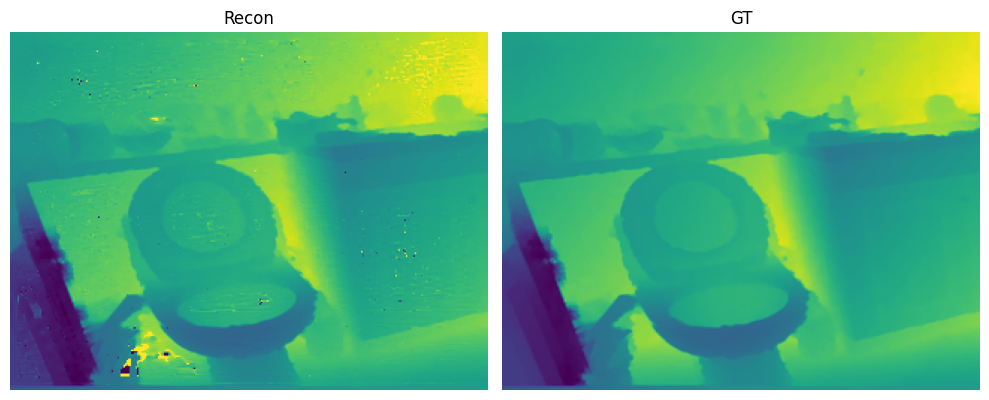

In [9]:
utils.plot_compare_greyscale(dpt.cpu(), gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()


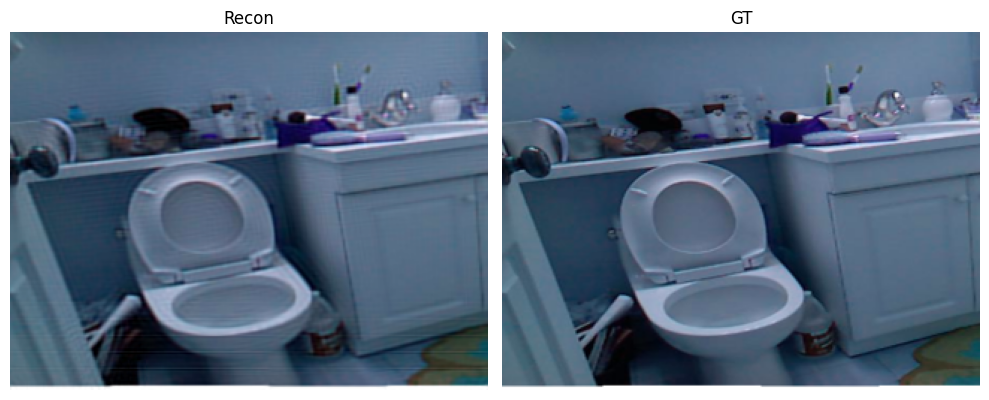

In [10]:
utils.plot_compare_rgb(aif.cpu(), gt_aif)
plt.show()

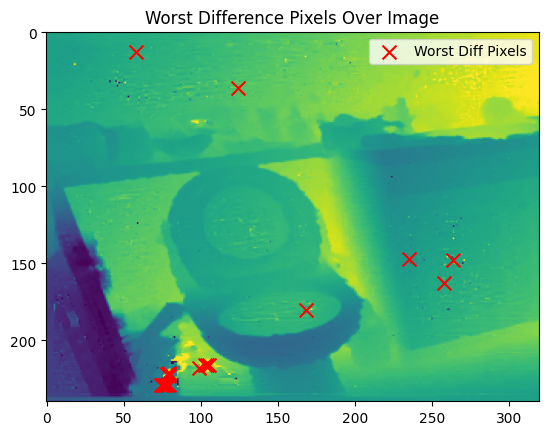

Grid search         : 100%|███████████████████| 100/100 [02:58<00:00,  1.79s/it]


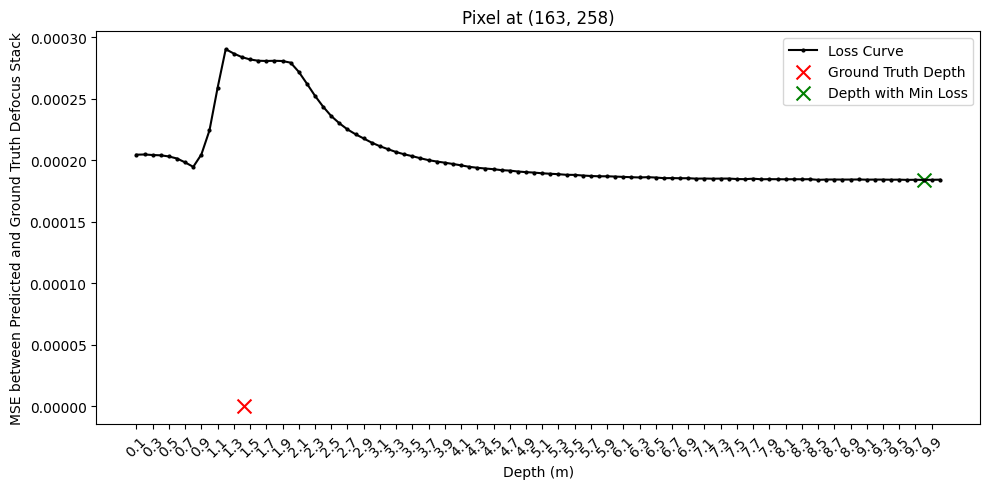

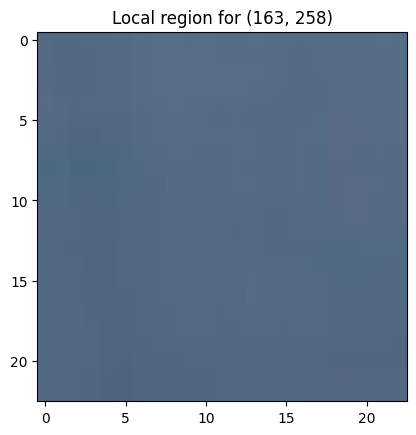

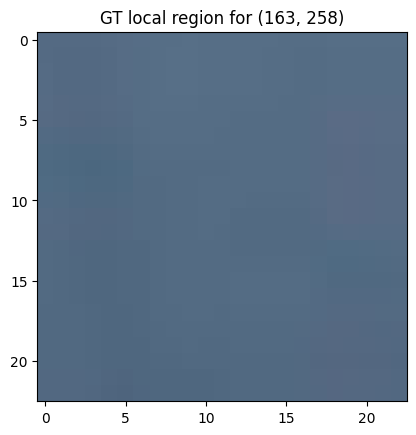

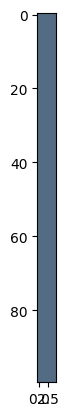

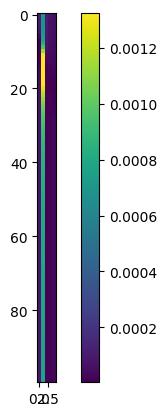

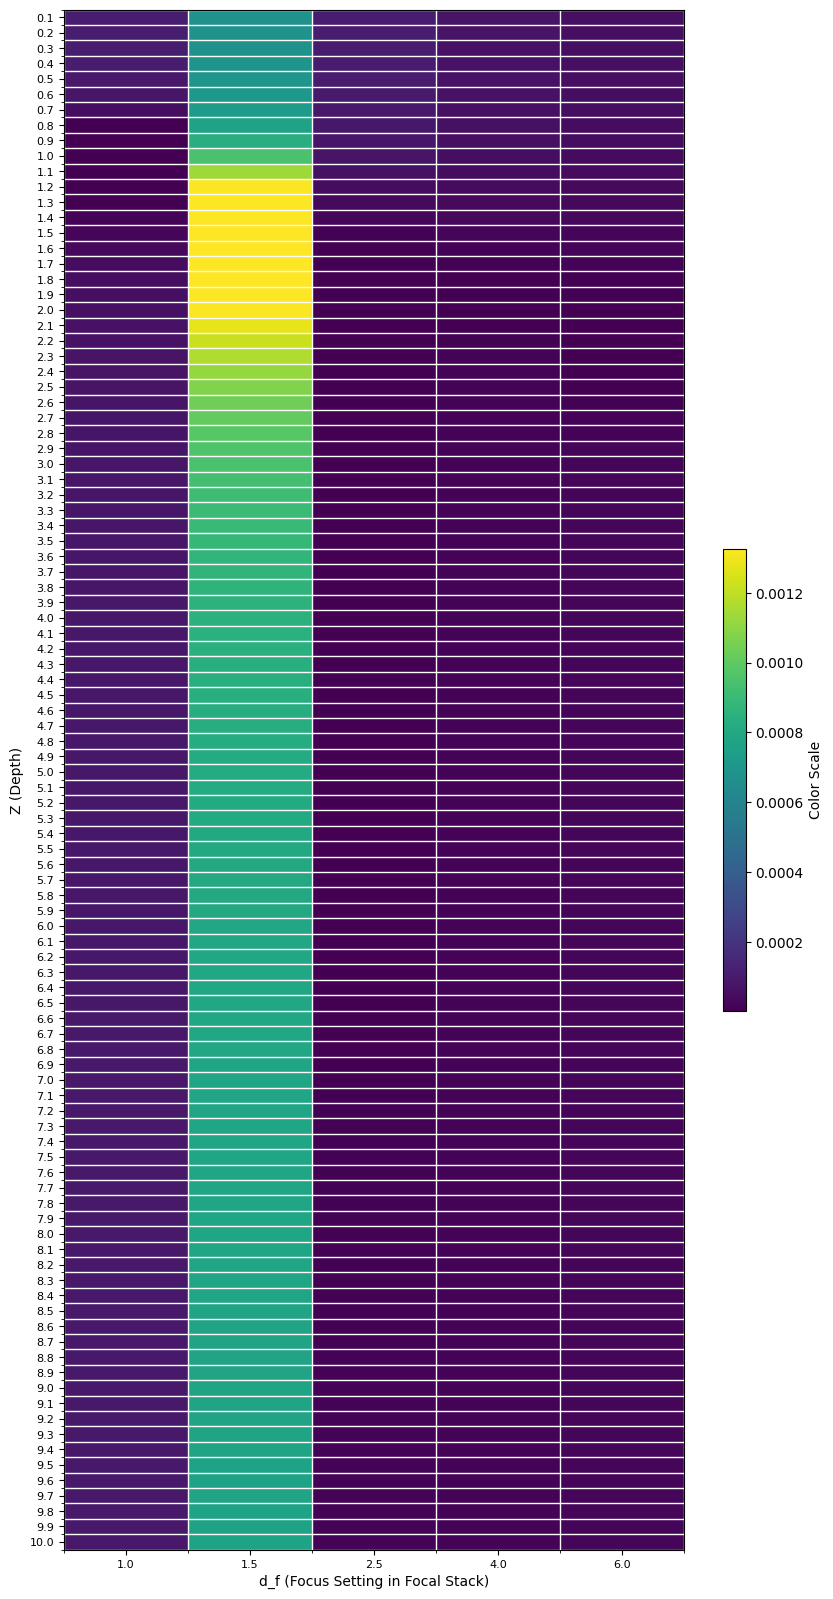

In [11]:
worst_coords = utils.get_worst_diff_pixels(dpt.cpu(), gt_dpt,
    num_worst_pixels = 20)

_, Z, _, all_losses = section_search.grid_search(aif.cpu(), defocus_stack_torch.cpu())

indices = forward_model.precompute_indices(width, height)
defocus_stacks = torch.zeros((len(Z), 5, width, height, 3))
for k in range(len(Z)):
    defocus_stack_k = forward_model.forward_torch(torch.full((width,height), Z[k]).to(aif.device),
                                                  aif, indices=indices)

    defocus_stacks[k] = defocus_stack_k

for i, j in worst_coords[:10]:
    section_search.plot_grid_search_on_pixel(i.item(), j.item(), Z, all_losses, gt_dpt)
    
    i_min = max(0, i.item()-max_kernel_size)
    i_max = min(width, i.item()+max_kernel_size+1)
    j_min = max(0, j.item()-max_kernel_size)
    j_max = min(height, j.item()+max_kernel_size+1)
    plt.imshow(aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    plt.title("Local region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    plt.imshow(gt_aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    plt.title("GT local region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()

    
    # plt.imshow(defocus_stacks[:,:,i.item(),j.item(),:] / 255.)
    # plt.show()

    
    mse = torch.mean((defocus_stacks[:,:,i.item(),j.item(),:] - defocus_stack_torch[:,i.item(),j.item(),:]) ** 2, axis=2)
    # plt.imshow(mse)
    # plt.colorbar()
    # plt.show()

    fig, ax = plt.subplots(figsize=(10, 20))
    cax = ax.imshow(mse, cmap="viridis", aspect="auto", interpolation="nearest")
    
    cbar = plt.colorbar(cax, ax=ax, shrink=0.3)
    cbar.set_label("Color Scale")
    
    ax.set_yticks(np.arange(len(Z)))
    ax.set_yticklabels([np.round(z,2) for z in Z], fontsize=8)
    ax.set_ylabel('Z (Depth)', fontsize=10)
    
    ax.set_xticks(np.arange(len(globals.Df)))
    ax.set_xticklabels([df.item() for df in globals.Df], fontsize=8)
    ax.set_xlabel('d_f (Focus Setting in Focal Stack)', fontsize=10)
    
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1)
    ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 100, 1), minor=True)
    
    plt.show()

    # break

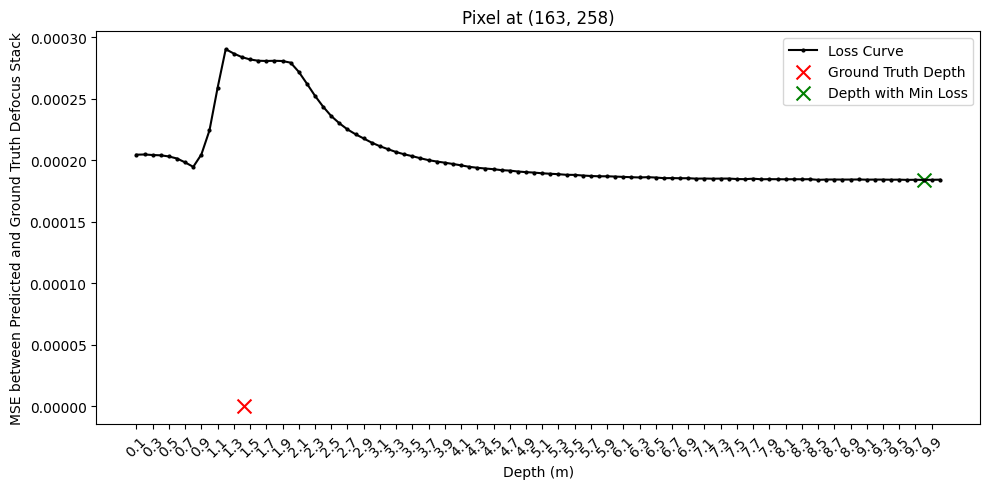

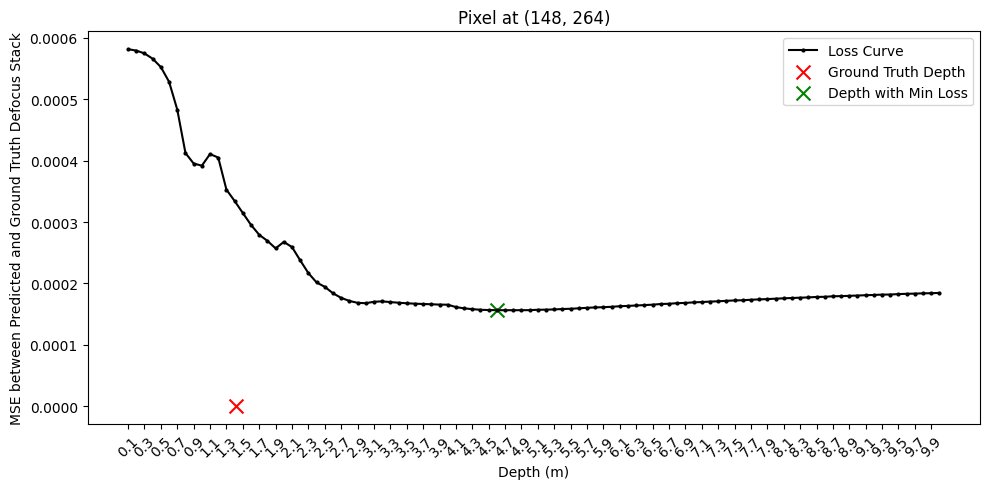

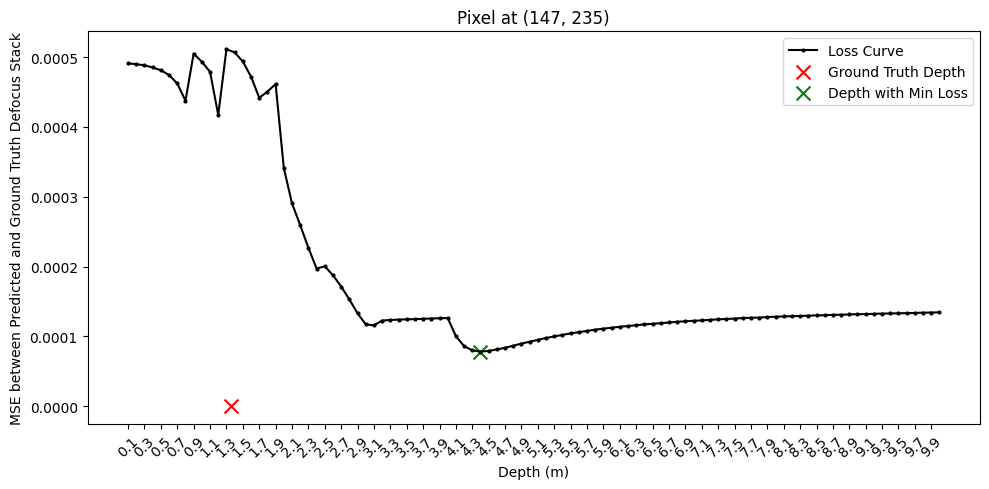

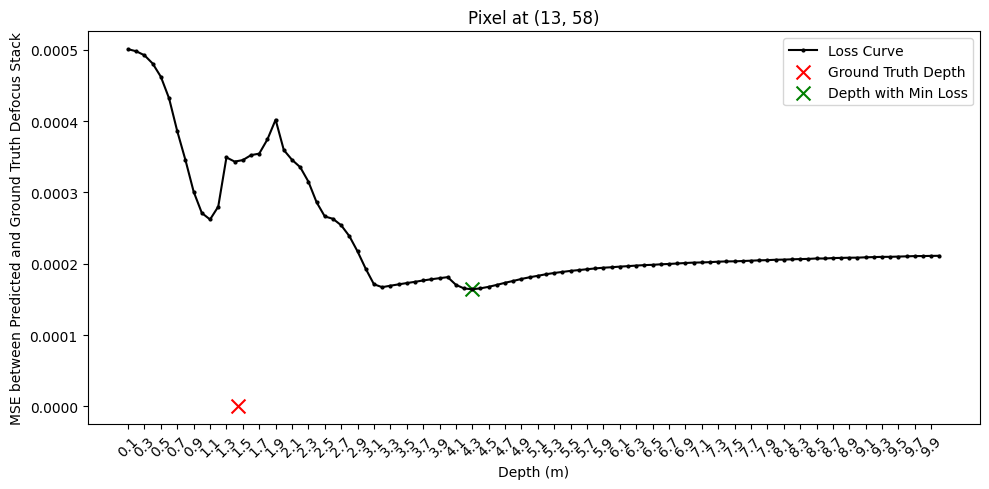

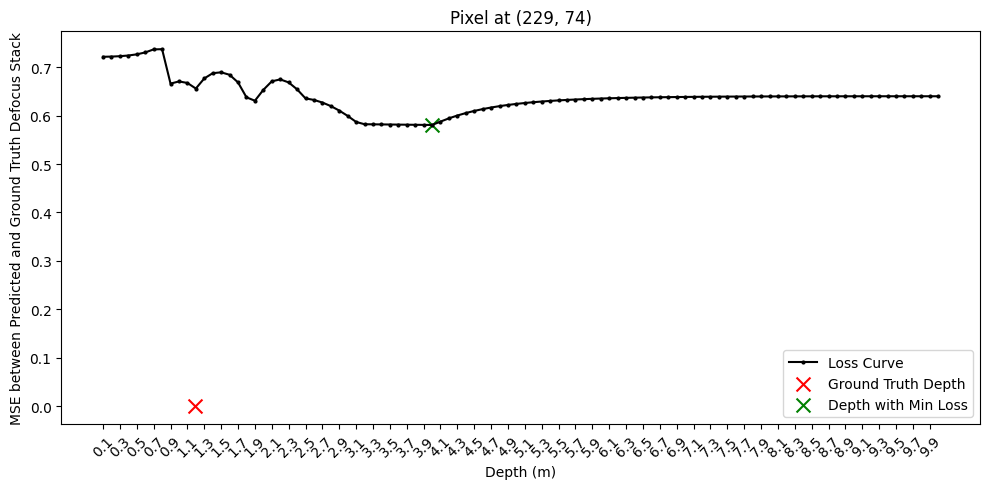

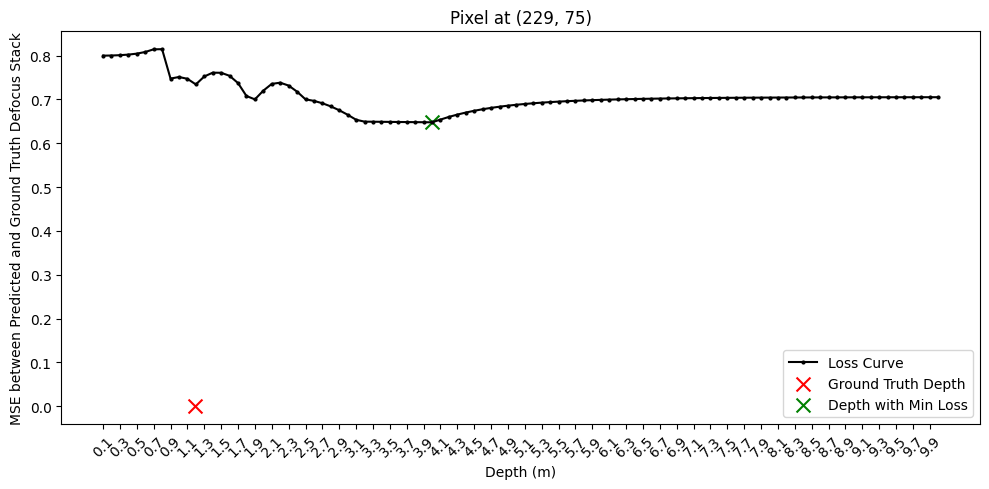

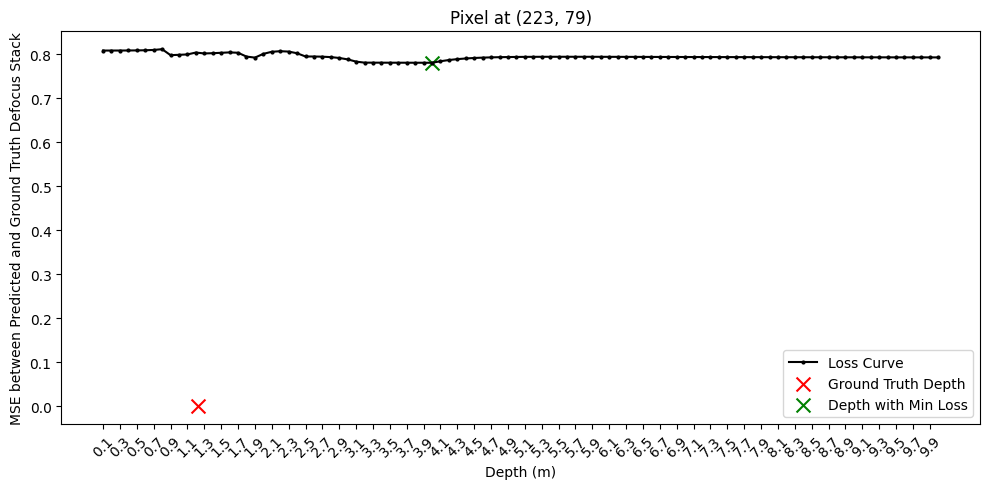

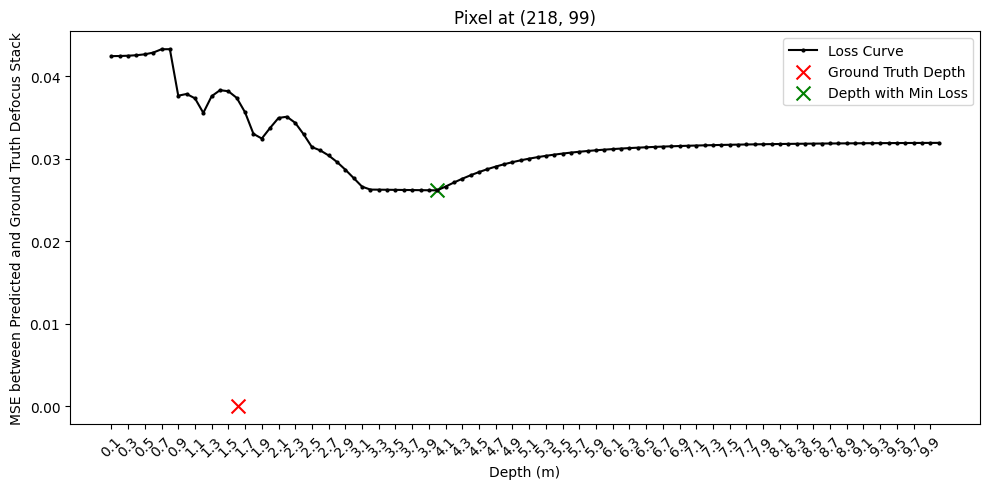

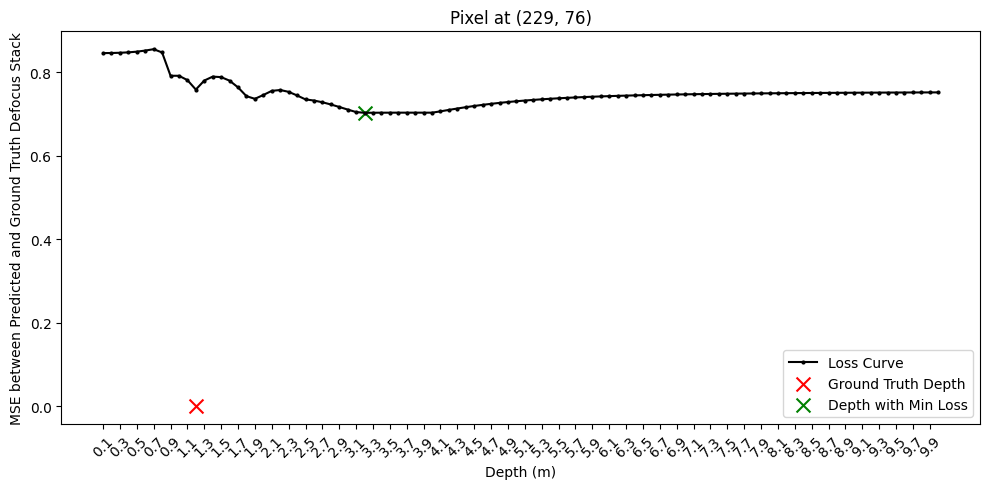

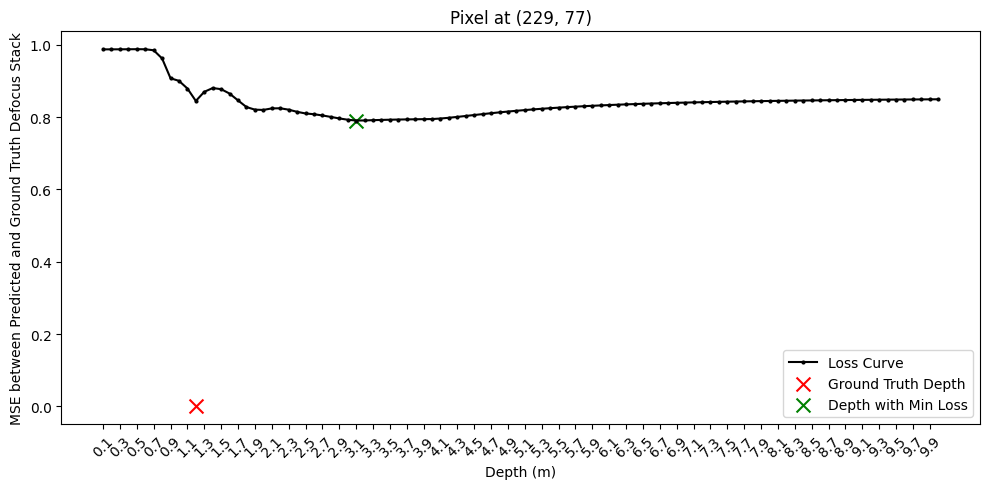

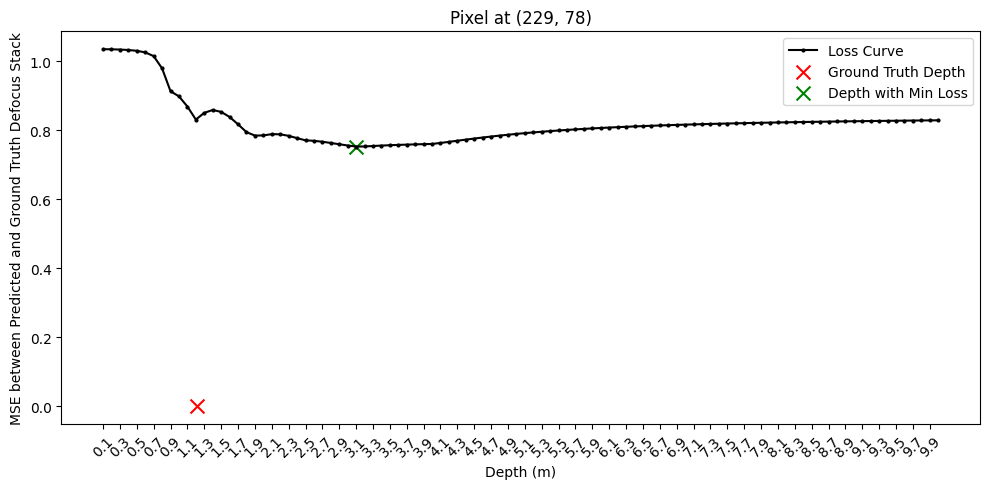

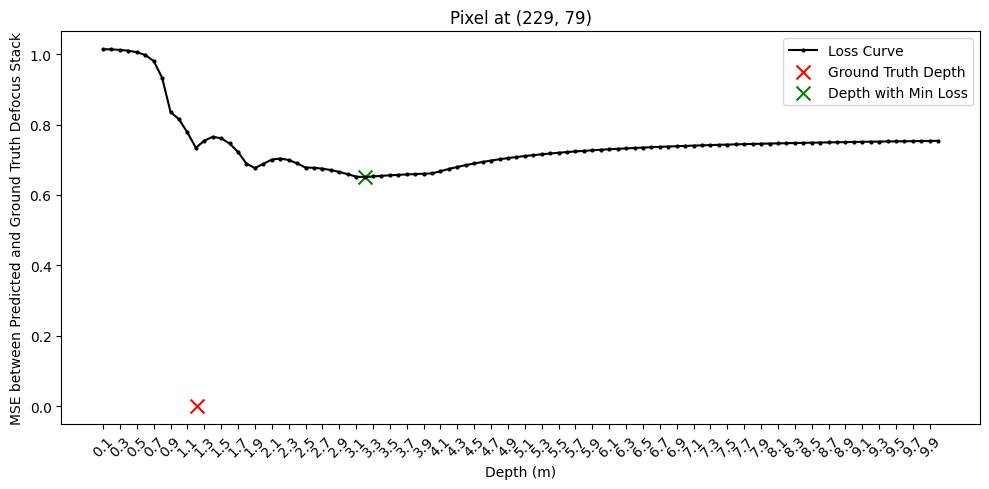

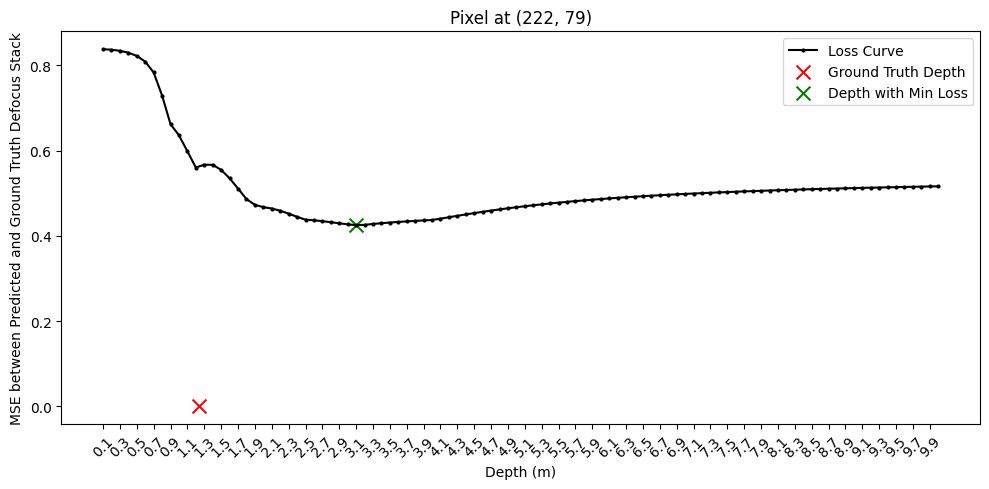

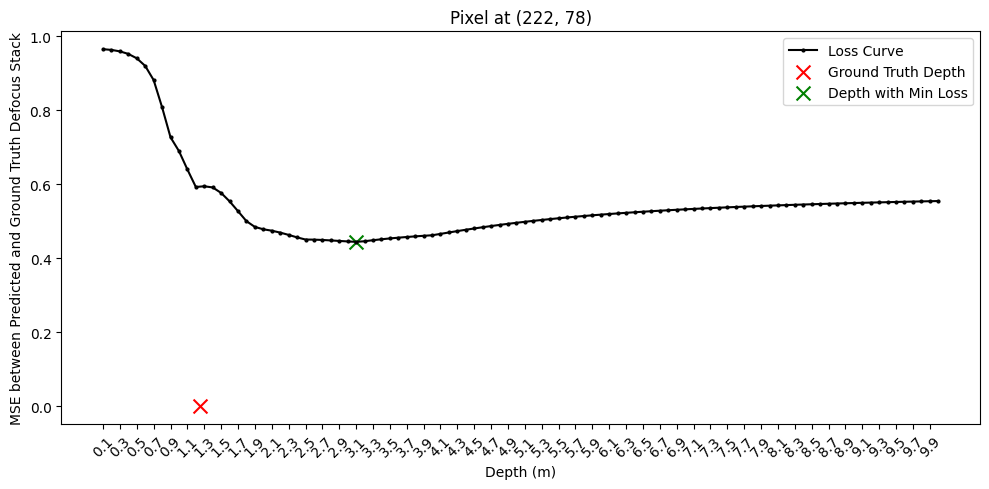

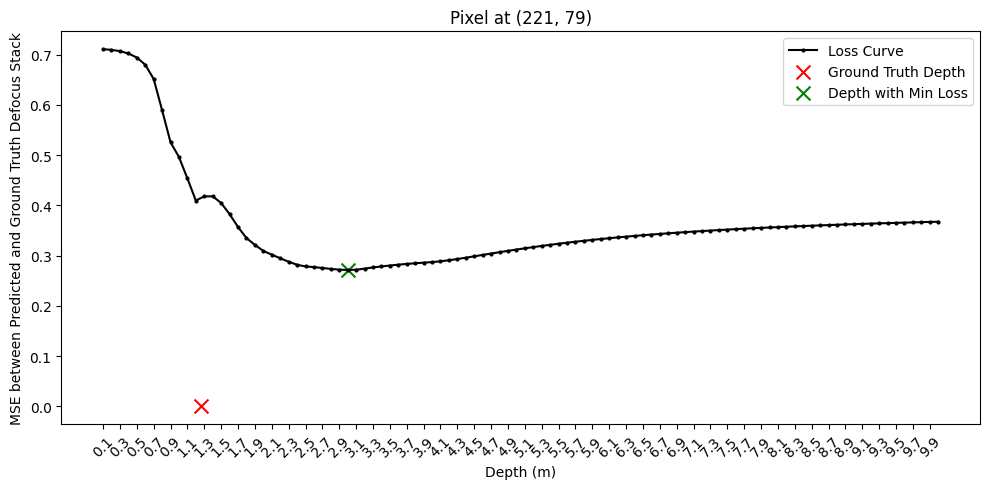

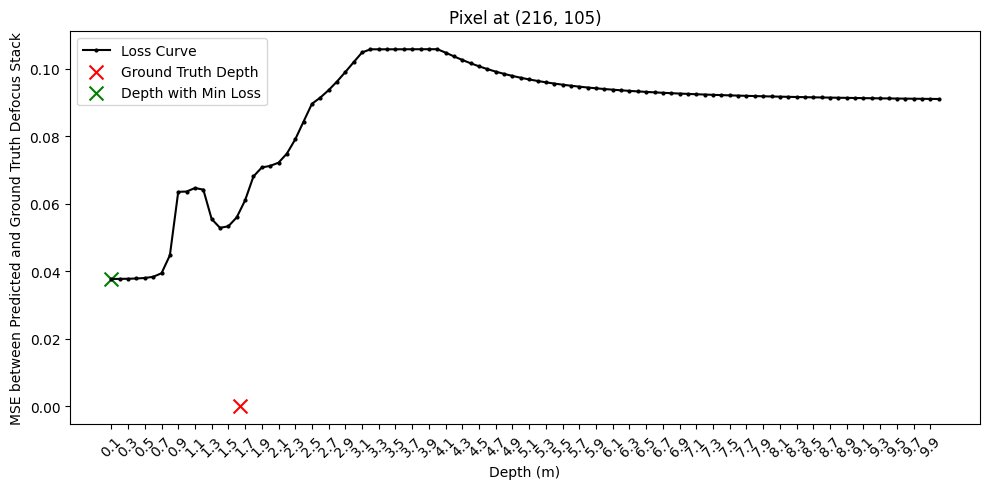

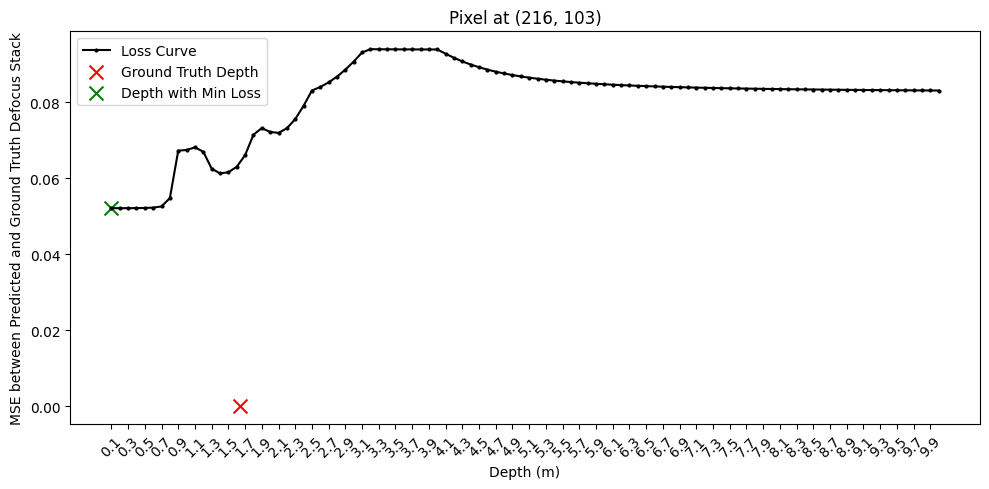

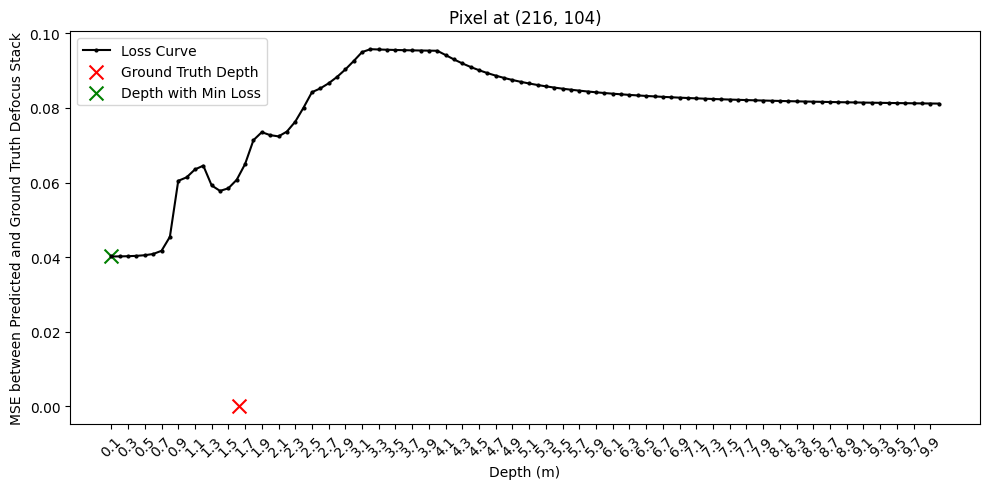

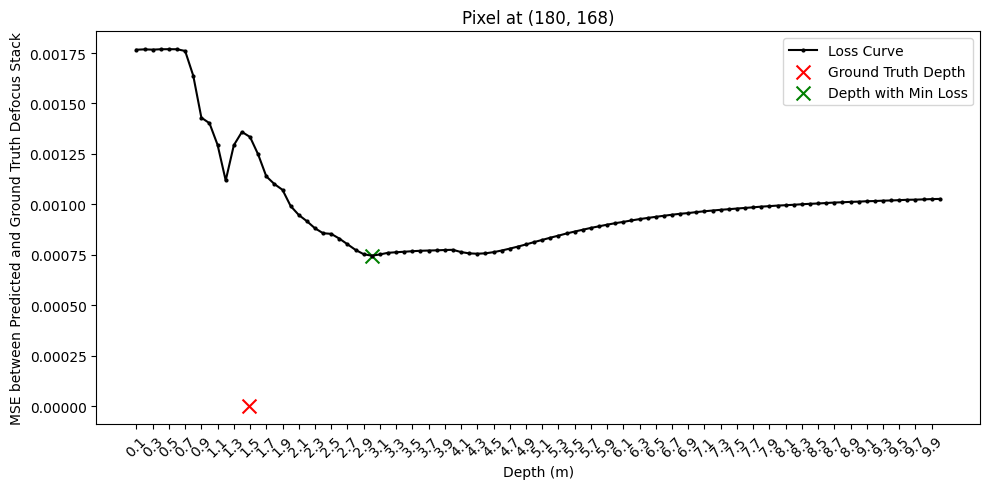

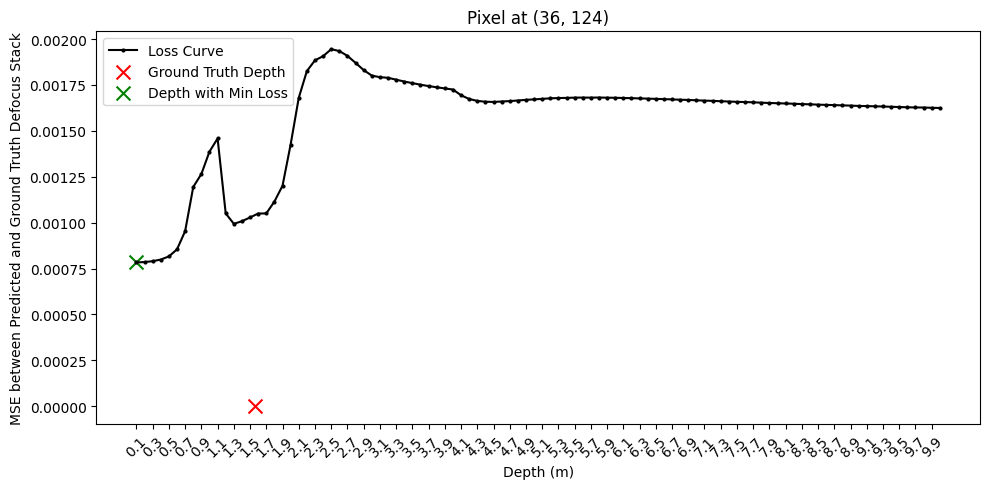

In [20]:
for i, j in worst_coords:
    section_search.plot_grid_search_on_pixel(i.item(), j.item(), Z, all_losses, gt_dpt)
    

In [12]:
print(dpt.cpu()[i.item(),j.item()])
print(gt_dpt.cpu()[i.item(),j.item()])

tensor(9.6966, dtype=torch.float64)
tensor(1.4249)


In [13]:
u, v, row, col, mask = indices

r = forward_model.computer(gt_dpt, globals.Df)
print(r.shape)
_, _, fs = r.shape
r = r.unsqueeze(-1).unsqueeze(-1)
    
G, _ = forward_model.computeG(r, u, v)
print(G.shape)

torch.Size([240, 320, 5])
torch.Size([240, 320, 5, 11, 11])


In [14]:
print(r[i.item(),j.item()])

tensor([[[4.0871]],

        [[2.0000]],

        [[4.0099]],

        [[5.9573]],

        [[7.0265]]])


tensor(1.0000)
tensor(1.)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)


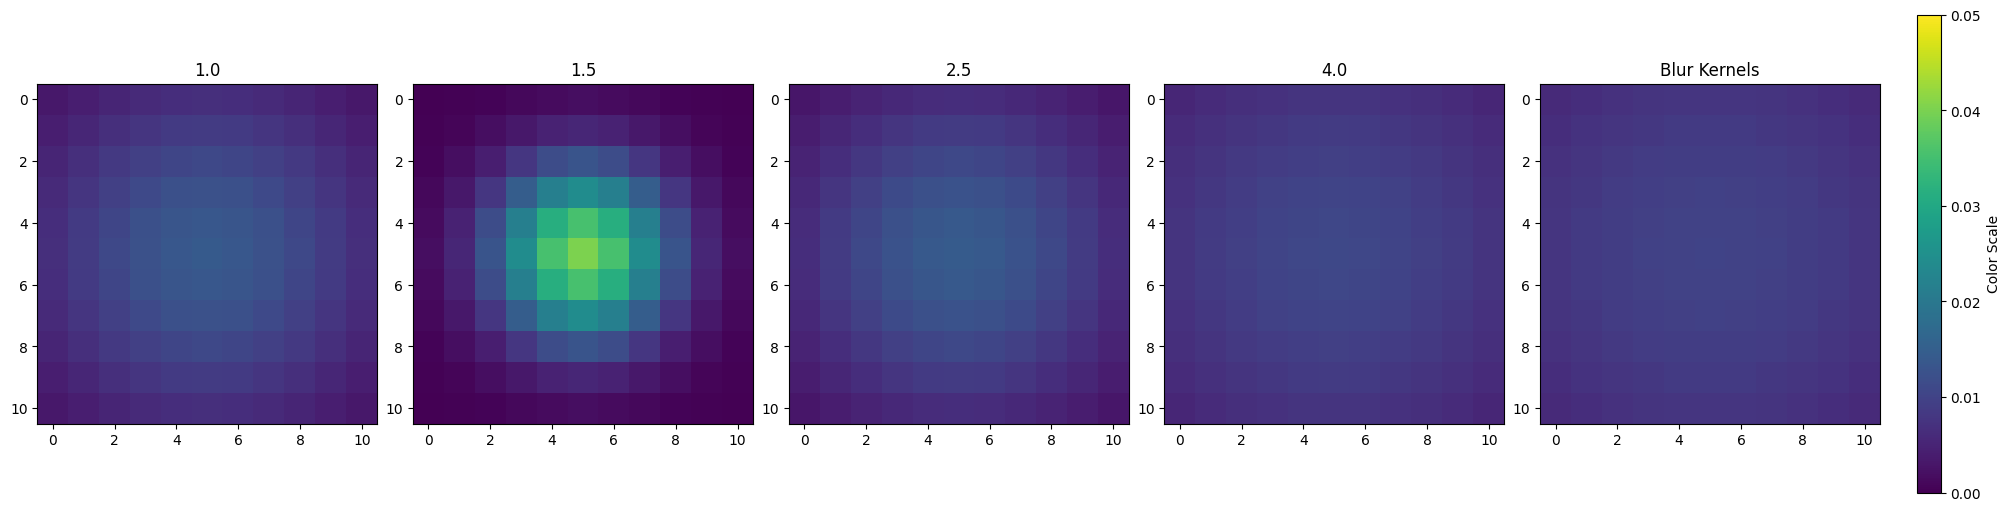

In [15]:
num_plots = len(globals.Df)
fig, axes = plt.subplots(1, num_plots, figsize=(20, 5), constrained_layout=True)

vmin = 0#torch.min(G[222, 178, :, :, :]).item()
vmax = 0.05#torch.max(G[222, 178, :, :, :]).item()

# Plot each subplot with a shared color scale
for k in range(num_plots):
    im = axes[k].imshow(G[i.item(), j.item(), k, :, :].cpu(), vmin=vmin, vmax=vmax)  # Ensure it's on CPU for plotting
    axes[k].set_title(globals.Df[k].item())
    print(G[i.item(), j.item(), k, :, :].sum())

# Create a global colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("Color Scale")

# Show the figure
plt.title('Blur Kernels')
plt.show()

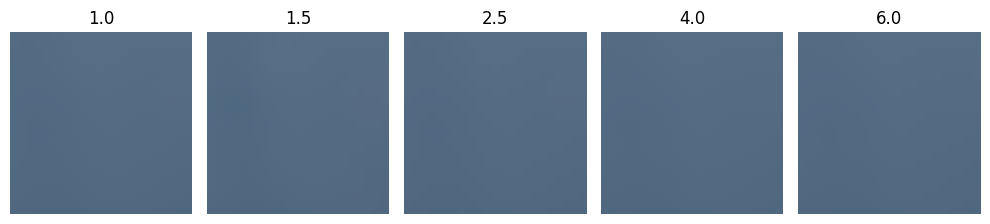

In [16]:
utils.plot_single_stack(defocus_stack_torch[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


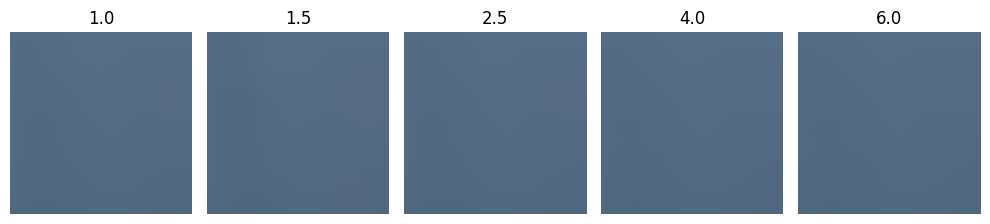

In [17]:
utils.plot_single_stack(forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [18]:
print(u.shape, v.shape, r.shape, G.shape)

torch.Size([1, 1, 1, 11, 11]) torch.Size([1, 1, 1, 11, 11]) torch.Size([240, 320, 5, 1, 1]) torch.Size([240, 320, 5, 11, 11])


In [19]:
print(defocus_stack_torch[i.item(),j.item()])

IndexError: index 163 is out of bounds for dimension 0 with size 5

In [ ]:
forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:]